In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Pentru Conferinta

Early stopping at epoch 10

===== CNN Metrics =====
Accuracy: 0.8132
F1 (macro): 0.8123
F1 (micro): 0.8132
ROC-AUC: 0.8905
Class 0: Precision=0.7741, Recall=0.8846, F1=0.8257
Class 1: Precision=0.8654, Recall=0.7418, F1=0.7989
Specificity (class 0): 0.8846
NPV (class 0): 0.7741

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.83      8269
           1       0.87      0.74      0.80      8269

    accuracy                           0.81     16538
   macro avg       0.82      0.81      0.81     16538
weighted avg       0.82      0.81      0.81     16538



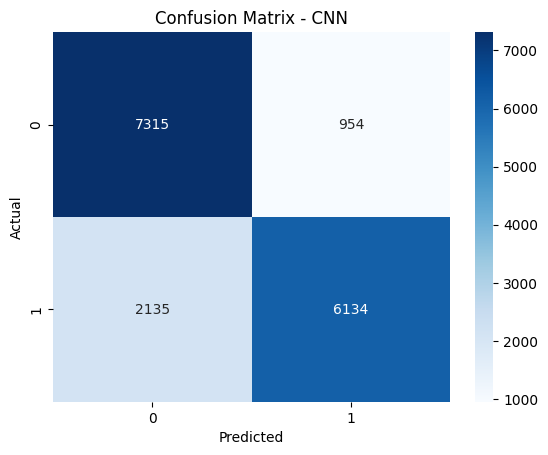

In [4]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from spikingjelly.activation_based.ann2snn import Converter

# --- DATA PREP ---
df = pd.read_excel("C:/woic/1sorted.xlsx")
label_dict = dict(zip(df["Participant_ID"], df["PHQ8_Binary"]))
spectrogram_paths = glob.glob("C:/2Spectrogram/*.png")
X, y = [], []
for path in spectrogram_paths:
    filename = os.path.basename(path)
    participant_id = int(filename.split('_')[0])
    if participant_id in label_dict:
        label = label_dict[participant_id]
    else:
        continue
    img = Image.open(path).convert('L').resize((128,128))
    X.append(np.array(img))
    y.append(label)
X = np.array(X, dtype="float32")
y = np.array(y, dtype="float32")

X_smote = X.reshape(len(X), -1)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_smote, y)
X_res = X_res.reshape(-1, 128, 128, 1)
X_res /= 255.
X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

class SpectrogramDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).unsqueeze(1).float() if X.ndim == 3 else torch.tensor(X).permute(0,3,1,2).float()
        self.y = torch.tensor(y).long()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = SpectrogramDataset(X_train.squeeze(-1), y_train)
val_ds = SpectrogramDataset(X_val.squeeze(-1), y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 30 * 30, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    def forward(self, x): return self.network(x)

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def print_all_metrics(y_true, y_pred, y_score, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    print(f"\n===== {model_name} Metrics =====")
    print(f"Accuracy: {report['accuracy']:.4f}")
    print(f"F1 (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 (micro): {f1_score(y_true, y_pred, average='micro'):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_score):.4f}")
    for cls in ['0', '1']:
        if cls in report:
            print(f"Class {cls}: Precision={report[cls]['precision']:.4f}, Recall={report[cls]['recall']:.4f}, F1={report[cls]['f1-score']:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2,2):
        TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else float('nan')
        npv = TN / (TN + FN) if (TN + FN) > 0 else float('nan')
        print(f"Specificity (class 0): {specificity:.4f}")
        print(f"NPV (class 0): {npv:.4f}")
    else:
        print("Specificity and NPV only valid for binary problems.")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred, f"Confusion Matrix - {model_name}")



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
best_model_state = None
patience = 5
patience_counter = 0

for epoch in range(50):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            val_loss += criterion(out, yb).item()
    val_loss /= len(val_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

torch.save(model.state_dict(), "ENERGY1.pth")

    
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_score = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            probs = F.softmax(out, dim=1)[:,1].cpu().numpy()
            preds = torch.argmax(out, dim=1).cpu().numpy()
            y_true.extend(yb.numpy())
            y_pred.extend(preds)
            y_score.extend(probs)
    return np.array(y_true), np.array(y_pred), np.array(y_score)

y_true, y_pred, y_score = evaluate(model, val_loader)

print_all_metrics(y_true, y_pred, y_score, "CNN")

SNN CONVERSION AND SIMULATION 

----------------------------------------
Converting with mode=max


100%|██████████| 2068/2068 [00:07<00:00, 279.76it/s]


Simulating SNN...

===== SNN (mode=max) Metrics =====
Accuracy: 0.8137
F1 (macro): 0.8136
F1 (micro): 0.8137
ROC-AUC: 0.8371
Class 0: Precision=0.8005, Recall=0.8357, F1=0.8177
Class 1: Precision=0.8281, Recall=0.7918, F1=0.8095
Specificity (class 0): 0.8357
NPV (class 0): 0.8005

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      8269
           1       0.83      0.79      0.81      8269

    accuracy                           0.81     16538
   macro avg       0.81      0.81      0.81     16538
weighted avg       0.81      0.81      0.81     16538



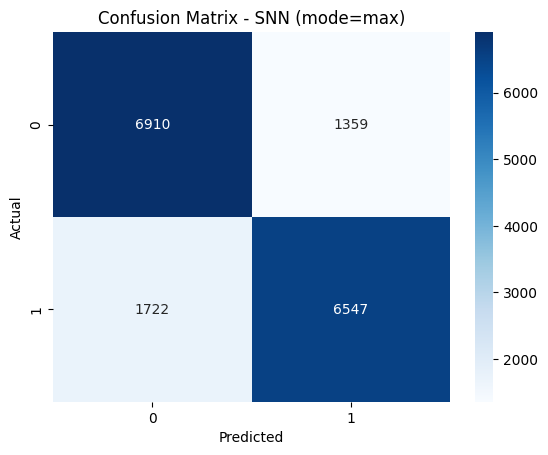

----------------------------------------
Converting with mode=99.9%


100%|██████████| 2068/2068 [05:44<00:00,  6.01it/s]


Simulating SNN...

===== SNN (mode=99.9%) Metrics =====
Accuracy: 0.8094
F1 (macro): 0.8083
F1 (micro): 0.8094
ROC-AUC: 0.8404
Class 0: Precision=0.7679, Recall=0.8868, F1=0.8231
Class 1: Precision=0.8661, Recall=0.7320, F1=0.7934
Specificity (class 0): 0.8868
NPV (class 0): 0.7679

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      8269
           1       0.87      0.73      0.79      8269

    accuracy                           0.81     16538
   macro avg       0.82      0.81      0.81     16538
weighted avg       0.82      0.81      0.81     16538



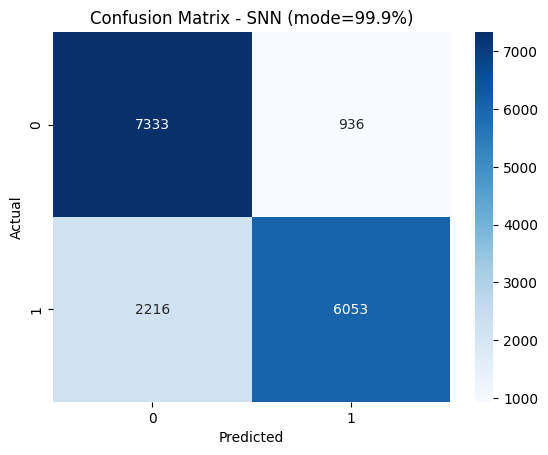

----------------------------------------
Converting with mode=0.5


100%|██████████| 2068/2068 [00:07<00:00, 280.36it/s]


Simulating SNN...

===== SNN (mode=0.5) Metrics =====
Accuracy: 0.8111
F1 (macro): 0.8104
F1 (micro): 0.8111
ROC-AUC: 0.8390
Class 0: Precision=0.7780, Recall=0.8707, F1=0.8217
Class 1: Precision=0.8532, Recall=0.7515, F1=0.7991
Specificity (class 0): 0.8707
NPV (class 0): 0.7780

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      8269
           1       0.85      0.75      0.80      8269

    accuracy                           0.81     16538
   macro avg       0.82      0.81      0.81     16538
weighted avg       0.82      0.81      0.81     16538



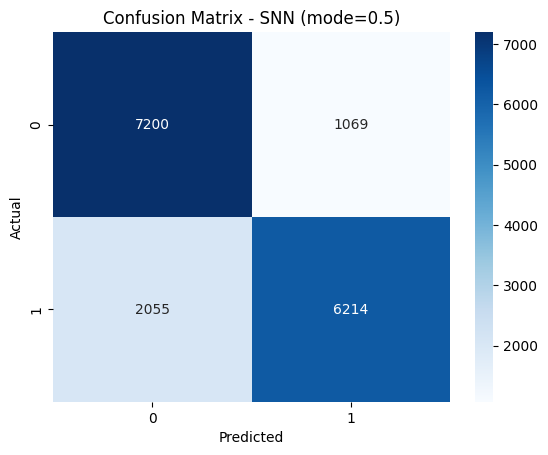

----------------------------------------
Converting with mode=0.3333333333333333


100%|██████████| 2068/2068 [00:07<00:00, 280.61it/s]


Simulating SNN...

===== SNN (mode=0.3333333333333333) Metrics =====
Accuracy: 0.8004
F1 (macro): 0.7990
F1 (micro): 0.8004
ROC-AUC: 0.8309
Class 0: Precision=0.7577, Recall=0.8832, F1=0.8157
Class 1: Precision=0.8600, Recall=0.7176, F1=0.7824
Specificity (class 0): 0.8832
NPV (class 0): 0.7577

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      8269
           1       0.86      0.72      0.78      8269

    accuracy                           0.80     16538
   macro avg       0.81      0.80      0.80     16538
weighted avg       0.81      0.80      0.80     16538



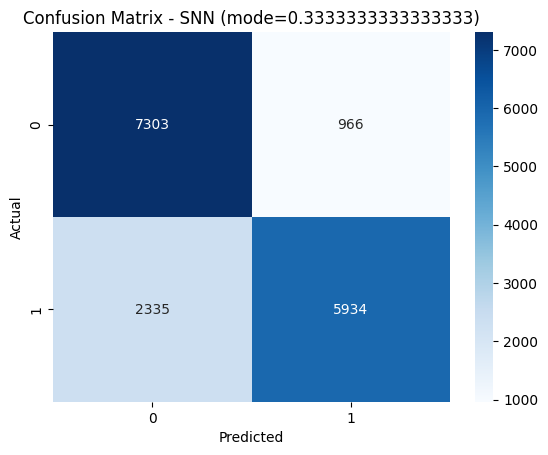

In [5]:
T = 50
modes = ['max', '99.9%', 1.0/2, 1.0/3]
results = {}

for mode in modes:
    print('-'*40)
    print(f'Converting with mode={mode}')
    converter = Converter(mode=mode, dataloader=train_loader)
    snn_model = converter(model)
    print('Simulating SNN...')

    def eval_snn(snn_model, loader, device, T=50):
        from spikingjelly.activation_based import functional
        snn_model.eval()
        y_true, y_pred, y_score = [], [], []
        total_spikes = 0
        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                functional.reset_net(snn_model)  # <-- THIS LINE FIXES THE ERROR
                spike_counts = torch.zeros((xb.shape[0], 2), device=device)
                for t in range(T):
                    out = snn_model(xb)
                    print(f"out (t={t}): {out}")
                    spike_counts += out
                    total_spikes += out.sum().item()
                print(f"energy: {total_spikes * 0.1e-9:.4f} J")
                print(f"spike_counts: {spike_counts}")

                probs = F.softmax(spike_counts, dim=1)[:,1].cpu().numpy()
                preds = torch.argmax(spike_counts, dim=1).cpu().numpy()
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds)
                y_score.extend(probs)
        return np.array(y_true), np.array(y_pred), np.array(y_score)

    
    y_true_snn, y_pred_snn, y_score_snn = eval_snn(snn_model, val_loader, device, T=T)

    print_all_metrics(y_true_snn, y_pred_snn, y_score_snn, f"SNN (mode={mode})")

    results[mode] = {
        "classification_report": classification_report(y_true_snn, y_pred_snn, output_dict=True),
        "F1": f1_score(y_true_snn, y_pred_snn),
        "ROC-AUC": roc_auc_score(y_true_snn, y_score_snn),
        "RMSE": np.sqrt(mean_squared_error(y_true_snn, y_pred_snn))
    }

In [4]:
import time

# Use val_loader or another DataLoader for your test set.
# Example: here it uses val_loader (already defined above)

n_samples = 1000
processed = 0
start = time.time()

model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        processed += xb.size(0)
        if processed >= n_samples:
            break

end = time.time()
actual_processed = min(n_samples, len(val_loader.dataset))
print(f"Inference on {actual_processed} samples took {end - start:.4f} seconds")
print(f"Average per sample: {(end - start)/actual_processed:.6f} seconds")


Inference on 1000 samples took 0.1033 seconds
Average per sample: 0.000103 seconds
